In [1]:
import os
import sys
import torch
import numpy as np
from timeit import default_timer as timer
from datetime import timedelta

BASE_DIR = os.path.dirname('./')
ROOT_DIR = os.path.dirname(BASE_DIR)
sys.path.append(ROOT_DIR)

import yaml

from lib.common.helpers.dataloader_helper import build_dataloader
from lib.common.helpers.model_helper import build_model
from lib.common.helpers.visualization_helper import visualization
from lib.common.helpers.print_helper import PrintHelper

In [2]:
mode = 'test' # test, eval, train
config = 'configs/kitti-multi.yaml'
from lib.monoDTR.printer import Printer as PrinterDTR
from lib.monoLSS.printer import Printer as PrinterLSS

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# load cfg
assert (os.path.exists(config))
cfg = yaml.load(open(config, 'r'), Loader=yaml.Loader)
  
#  build dataloader
dataset = build_dataloader(cfg['dataset'], mode)


printHelper = PrintHelper(dataset)


MonoDTR = PrinterDTR(cfg['MonoDTR'], build_model(cfg['MonoDTR']))
MonoLSS = PrinterLSS(cfg['MonoLSS'], build_model(cfg['MonoLSS']))


Using device: cuda


In [6]:
from lib.monoDTR.visualDet3D.networks.lib.ops.iou3d.iou3d import boxes_iou3d_gpu
from lib.common.helpers.detection_helper import detectionInfo

def compareAll(list1, list2):# Az összehasonlító mátrix inicializálása
    #list1 = np.array(list1)[:, 8:15].astype(np.float32)
    #list2 = np.array(list2)[:, 8:15].astype(np.float32)
    comparison_matrix = []

    for item1 in list1:
        row = []
        for item2 in list2:
            # Hívjuk meg a compare függvényt és adjuk hozzá a sorhoz
            result = compare(item1, item2)
            row.append(result)
        comparison_matrix.append(row)
    
    positions = []

    # Sorok legnagyobbja
    for row_idx, row in enumerate(comparison_matrix):
        max_value = max(row)
        if max_value != 0:
            max_pos = row.index(max_value)

            # Ellenőrizzük, hogy a max_value a sorában és oszlopában a legnagyobb-e
            if all(max_value >= comparison_matrix[row_idx][j] for j in range(len(row))) and \
               all(max_value >= comparison_matrix[i][max_pos] for i in range(len(comparison_matrix))):
                positions.append((row_idx, max_pos))

    return positions

def compare(item1, item2):
    info1 = detectionInfo(item1)
    info2 = detectionInfo(item2)
    bbox1 = np.array([info1.tx, info1.ty, info1.tz, info1.h, info1.w, info1.l, info1.rot_global]).astype(np.float32)
    bbox2 = np.array([info2.tx, info2.ty, info2.tz, info2.h, info2.w, info2.l, info2.rot_global]).astype(np.float32)


    return boxes_iou3d_gpu(torch.tensor(np.array([bbox1])).cuda(), torch.tensor(np.array([bbox2])).cuda()).detach().cpu().numpy()[0][0]


def average_lists(list1, list2):
    # Ellenőrizzük, hogy a listák azonos hosszúságúak-e
    if len(list1) != len(list2):
        raise ValueError("A listák hossza nem egyezik.")

    averaged_list = []

    for row1, row2 in zip(list1, list2):
        if len(row1) != len(row2):
            raise ValueError("A sorok hossza nem egyezik.")
        
        averaged_row = []
        for val1, val2 in zip(row1, row2):
            if isinstance(val1, (np.float32)) and isinstance(val2, (np.float32)):
                # Számok esetén az átlagot számoljuk
                averaged_row.append((val1 + val2) / 2)
            else:
                # Más típusok esetén az első értéket vesszük
                averaged_row.append(val1)
        
        averaged_list.append(averaged_row)

    return averaged_list

In [7]:
idx = 0


0
[['Car', 0, 0, 1.7246481, 673.74615, 172.31206, 724.52234, 198.70491, 1.3809762, 1.6940855, 4.047223, 4.8797975, 1.355557, 39.71255, 1.8484551, 0.9906061]]
[['Car', 0, 0, 2.0489254, 670.0772, 171.35146, 727.2319, 199.42964, 1.449631, 1.6322631, 3.7086508, 4.888465, 1.384347, 39.52617, 2.1717832, 0.44133794], ['Car', 0, 0, -1.621361, 716.1481, 173.38559, 782.31055, 224.14261, 1.4828445, 1.5809503, 3.7268245, 4.4745207, 1.5436879, 23.785065, -1.4301531, 0.10056068]]
0:00:00.136266
közös: 


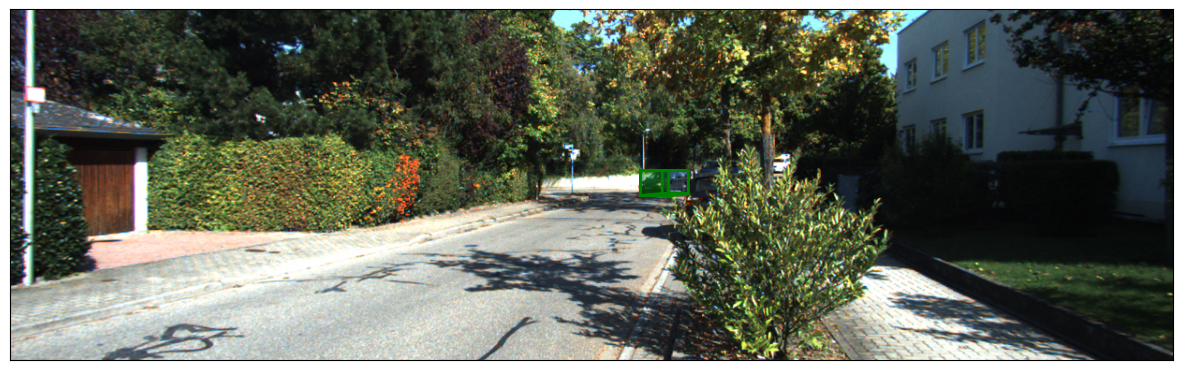

MonoLSS: 


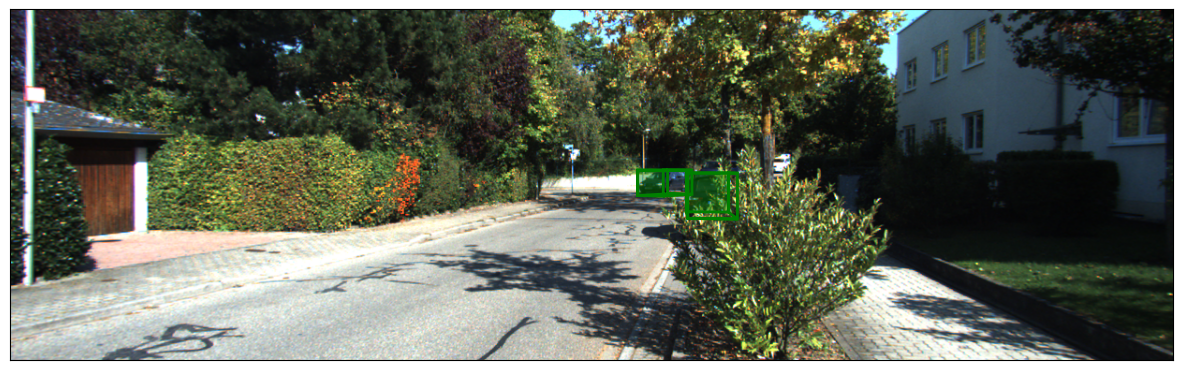

MonoDTR: 


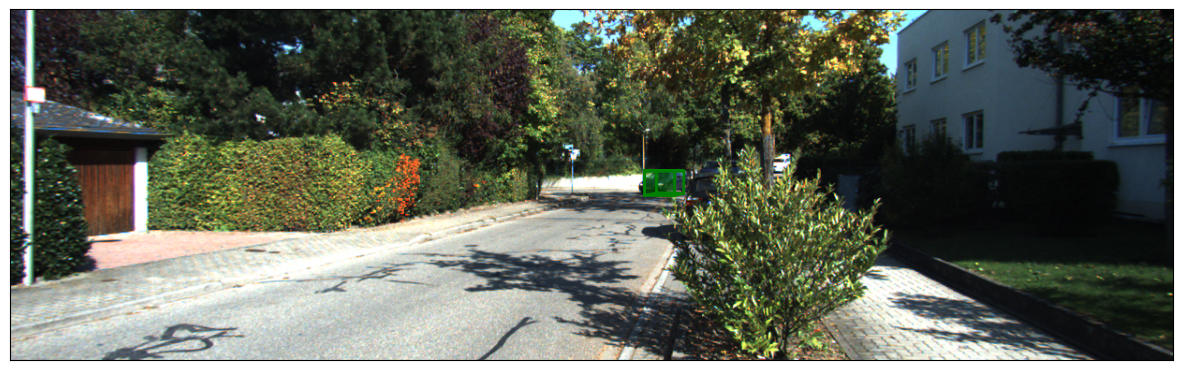

In [8]:
print(idx)

for x in range(1):
    img, calibs = printHelper.getPrintables(idx)
    
    torch.cuda.synchronize() # Wait for all kernels in all streams on a CUDA device to complete.
    start_time = timer()

    predsDTR = MonoDTR.print(img, calibs)
    predsLSS = MonoLSS.print(img, calibs)
    #print(predsDTR)
    #print(predsLSS)

    torch.cuda.synchronize() # Wait for all kernels in all streams on a CUDA device to complete.
    end_time = timer()
    print(timedelta(seconds=end_time - start_time))

    start_time = timer()
    
    same = compareAll(predsDTR,predsLSS)
    resultsLSS = []
    resultsDTR = []
    for dtr_idx, lss_idx in same:
        resultsLSS.append(predsLSS[lss_idx])
        resultsDTR.append(predsDTR[dtr_idx])

    result = average_lists(resultsLSS, resultsDTR)
    end_time = timer()
    print(timedelta(seconds=end_time - start_time))

    print('közös: ')
    visualization(img, calibs, result, False)

    #print(resultsLSS)
    #print(result)


    print('MonoLSS: ')
    visualization(img, calibs, predsLSS, False)
    #visualization(img, calibs, resultsLSS, False)

    print('MonoDTR: ')
    visualization(img, calibs, predsDTR, False)
    #visualization(img, calibs, resultsDTR, False)

    idx = idx +1